# Download the Dataset

In [1]:
# !pip install opendatasets

In [2]:
# import opendatasets as op
# op.download('https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia')

# Import Statements

In [3]:
import tensorflow as tf
from keras.datasets import mnist
import cv2
import os
import pathlib
from keras.layers import Conv2D, Conv2DTranspose, Dropout, Dense, Reshape, LayerNormalization, LeakyReLU
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score

2025-12-07 02:44:35.231966: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-07 02:44:35.232026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-07 02:44:35.233518: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-07 02:44:35.243413: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Reading the Dataset

In [4]:
import os
import cv2
import numpy as np
import pathlib

class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape

    def returnimagesaslist(self):
        self.images = []
        for label in self.labels:
            label_dir = os.path.join(self.datasetpath, label)
            image_files = list(pathlib.Path(label_dir).glob('*.[jJpP][pPnNgG]*'))
            self.images.append(image_files)

    def readImages(self):
        self.returnimagesaslist()
        self.finalImages = []
        labels = []

        for label_index in range(len(self.labels)):
            for img_path in self.images[label_index]:
                img = cv2.imread(str(img_path))
                if img is None:
                    print(f"Skipping: {img_path}")
                    continue

                try:
                    img = cv2.resize(img, self.image_shape)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = img / 255.0  # Normalize
                except Exception as e:
                    print(f"Error in {img_path}: {e}")
                    continue

                self.finalImages.append(img)
                labels.append(label_index)

        images = np.array(self.finalImages)
        labels = np.array(labels)

        print(f"Loaded {len(images)} images.")
        return images, labels


In [5]:
# import os
# print(os.listdir('chest_xray/chest_xray/train/NORMAL')[:5])

In [6]:
train_dataset = ReadDataset('chest_xray/chest_xray/train',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
X_train, y_train = train_dataset.readImages()

Loaded 5216 images.


In [7]:
X_train.shape, y_train.shape

((5216, 64, 64, 3), (5216,))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


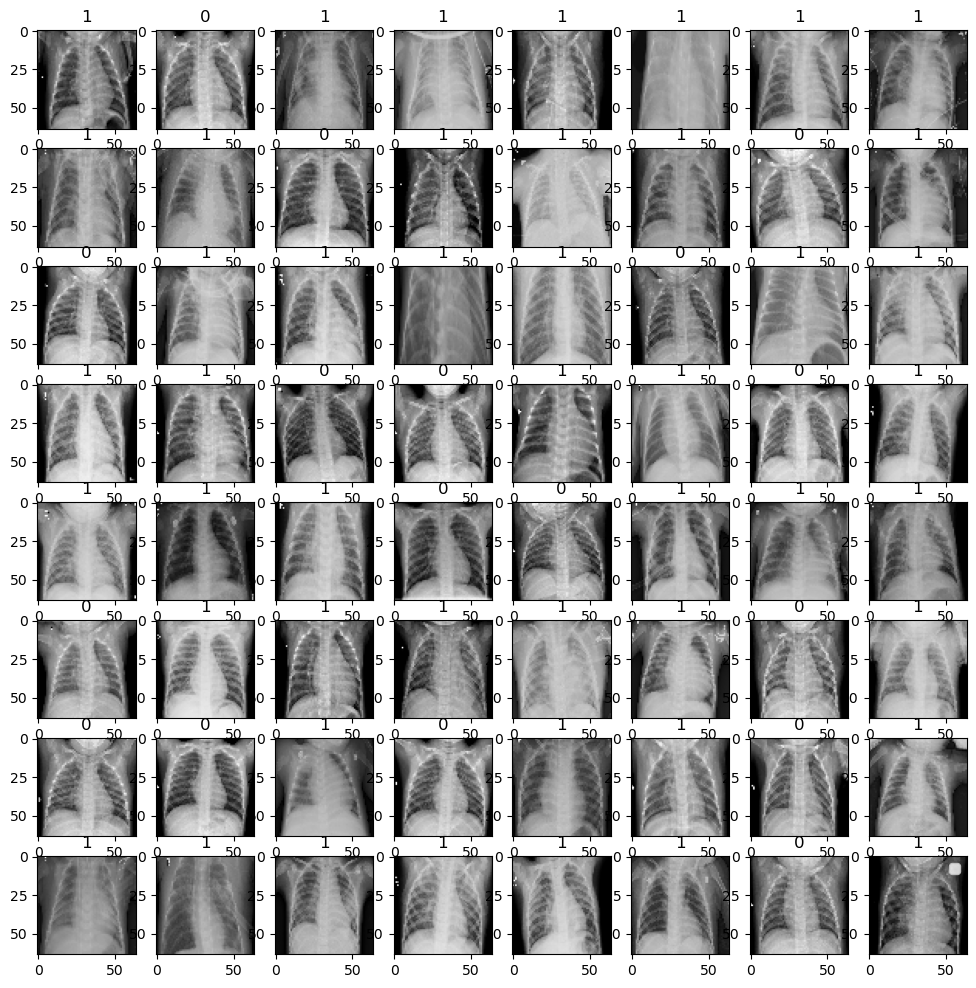

In [8]:
plt.figure(figsize = (12, 12))
indexs = np.random.randint(0, len(y_train), size = (64, ))
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(X_train[indexs[i]])
    plt.title(y_train[indexs[i]])
plt.legend()

# ACGAN Architecture

In [9]:
class ACGAN:
    def __init__(self, eta, batch_size, epochs, weight_decay, latent_space,
                 image_shape, kernel_size):
        self.eta = eta
        self.batch_size = batch_size
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.latent_space = latent_space
        self.image_shape = image_shape
        self.kernel_size = kernel_size
        
    def data(self, images, labels):
        ytrain = tf.keras.utils.to_categorical(labels)
        self.images = images
        self.labels = ytrain
        
    def samples(self, G, noize, labels):
        images = G.predict([noize, labels])
        ys = np.argmax(labels, axis = 1)
        plt.figure(figsize = (12, 4))
        for i in range(16):
            plt.subplot(2, 8, (i + 1))
            plt.imshow(images[i], cmap = 'gray')
            plt.title(ys[i])
        plt.show()
        
    def generator(self, inputs, labels):
        filters = [256, 128, 64, 32]
        padding = 'same'
        x = inputs
        y = labels
        x = layers.concatenate([x, y])
        x = layers.Dense(1024, )(x)
        x = layers.Dense(8*8*filters[0],
                         kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        x = layers.Reshape((8, 8, filters[0]))(x)
        for filter in filters:
            if filter >= 64:
                strides = 2
            else:
                strides = 1
            # x = LayerNormalization()(x)
            x = layers.BatchNormalization()(x)
            # x = layers.Activation('relu')(x)
            x = LeakyReLU(alpha=0.2)(x)
            # x = Conv2DTranspose(filter, kernel_size = self.kernel_size, padding = padding,
                      # strides = strides)(x)
            x = layers.UpSampling2D(size=(strides, strides))(x)
            x = Conv2D(filter, kernel_size=self.kernel_size, padding=padding)(x)
        x = Conv2DTranspose(3, kernel_size = self.kernel_size, padding = padding)(x)
        x = layers.Activation('sigmoid')(x)
        #ADDED NEXT LINE - Ablation
        # x = tf.image.resize(x, (75,75), method='bilinear')
        self.generatorModel = models.Model(inputs = [inputs, labels],
                                           outputs = x,
                                           name = 'generator')
        
    def discriminator(self, inputs):
        x = inputs
        filters = [32, 64, 128, 256]
        padding = 'same'
        for filter in filters:
            if filter < 256:
                strides = 2
            else:
                strides = 1
            x = Conv2D(filter, kernel_size = self.kernel_size, padding = padding,
                      strides = strides,
                      kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
            x = LeakyReLU(alpha = 0.2)(x)
        x = layers.Flatten()(x)
        outputs = Dense(1, )(x)
        labelsOutput = Dense(256,
                             kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        labelsOutput = Dropout(0.3)(labelsOutput)
        labelsOutput = Dense(2,)(labelsOutput)
        labelsOutput = layers.Activation('softmax')(labelsOutput)
        self.discriminatorModel = models.Model(inputs = inputs,
                                               outputs = [outputs, labelsOutput],
                                               name = 'discriminator')
        
    def build(self,):
        generatorInput = layers.Input(shape = (self.latent_space))
        discriminatorInput = layers.Input(shape = (self.image_shape))
        labelsInput = layers.Input(shape = (2, ))
        self.generator(generatorInput, labelsInput)
        self.discriminator(discriminatorInput)
        G = self.generatorModel
        D = self.discriminatorModel
        D.compile(loss = ['mse', 'binary_crossentropy'],
                 optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta,
                                                        weight_decay = self.weight_decay))
        D.summary()
        G.summary()
        D.trainable = False
        GAN = models.Model(inputs = [generatorInput, labelsInput],
                           outputs = D(G([generatorInput, labelsInput])))
        GAN.compile(loss = ['mse', 'binary_crossentropy'],
                   optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta*0.5,
                                                          weight_decay = self.weight_decay*0.5))
        GAN.summary()
        return G, D, GAN
        
    def trainAlgorithm(self, G, D, GAN):
        for epoch in range(self.epochs):
            indexs = np.random.randint(0, len(self.images), size = (self.batch_size, ))
            realImages = self.images[indexs]
            realLabels = self.labels[indexs]
            realTag = tf.ones(shape = (self.batch_size, ))
            noize = tf.random.uniform(shape = (self.batch_size,
                                              self.latent_space), minval = -1,
                                     maxval = 1)
            fakeLabels = tf.keras.utils.to_categorical(np.random.choice(range(2), size = (self.batch_size)),
                                                      num_classes = 2)
            fakeImages = tf.squeeze(G.predict([noize, fakeLabels], verbose = 0))
            fakeTag = tf.zeros(shape = (self.batch_size, ))
            allImages = np.vstack([realImages, fakeImages])
            allLabels = np.vstack([realLabels, fakeLabels])
            allTags = np.hstack([realTag, fakeTag])
            _, dlossTag, dlossLabels = D.train_on_batch(allImages, [allTags, allLabels])
            noize = tf.random.uniform(shape = (self.batch_size,
                                              self.latent_space), minval = -1,
                                     maxval = 1)
            _, glossTag, glossLabels = GAN.train_on_batch([noize, fakeLabels], [realTag, fakeLabels])
            if epoch % 5000 == 0:
                print('Epoch: {}'.format(epoch))
                print('discriminator loss: [tag: {}, labels: {}], generator loss: [tag: {}, labels: {}]'.format(dlossTag,
                                                                                                                dlossLabels,
                                                                                                                glossTag,
                                                                                                                glossLabels))
                self.samples(G, noize, fakeLabels)

In [10]:
ac_gan = ACGAN(eta = 0.0001, batch_size = 32, epochs = 32000, weight_decay = 6e-9,
              latent_space = 100, image_shape = (64, 64, 3), kernel_size = 5)

In [11]:
ac_gan.data(X_train, y_train)

In [12]:
generator, discriminator, GAN = ac_gan.build()

2025-12-07 02:45:19.320021: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10534 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:8a:00.0, compute capability: 6.1


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 32, 32, 32)           2432      ['input_2[0][0]']             
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 32)           0         ['conv2d_4[0][0]']            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 16, 16, 64)           51264     ['leaky_re_lu_4[0][0]']       
                                                                                      

In [13]:
GAN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 generator (Functional)      (None, 64, 64, 3)            1961837   ['input_1[0][0]',             
                                                          1          'input_3[0][0]']             
                                                                                                  
 discriminator (Functional)  [(None, 1),                  5289539   ['generator[0][0]']       

In [14]:
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 102)                  0         ['input_1[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 dense (Dense)               (None, 1024)                 105472    ['concatenate[0][0]'] 

In [15]:
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 32, 32, 32)           2432      ['input_2[0][0]']             
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 32)           0         ['conv2d_4[0][0]']            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 16, 16, 64)           51264     ['leaky_re_lu_4[0][0]']       
                                                                                      

2025-12-07 02:46:13.151591: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-12-07 02:46:16.957687: I external/local_xla/xla/service/service.cc:168] XLA service 0x7febc9ed6fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-07 02:46:16.957732: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-12-07 02:46:16.964265: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1765075577.047032 4028473 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch: 0
discriminator loss: [tag: 0.4754577875137329, labels: 0.6991221904754639], generator loss: [tag: 0.10385523736476898, labels: 0.7030361890792847]
1/1 [==============================] - 0s 26ms/step


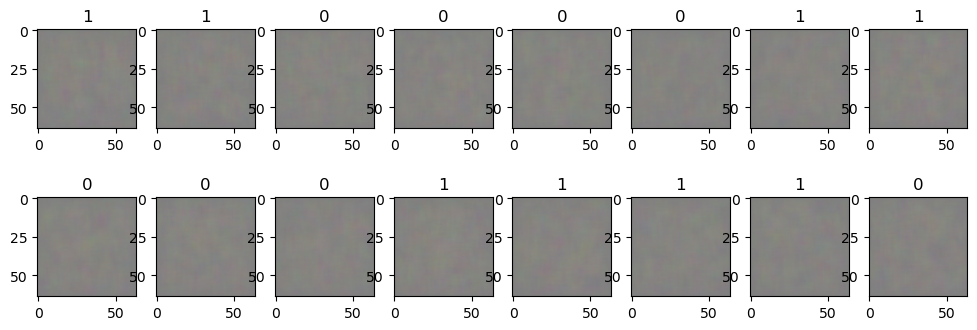

Epoch: 5000
discriminator loss: [tag: 0.21906669437885284, labels: 0.017962127923965454], generator loss: [tag: 0.36883026361465454, labels: 0.013162749819457531]
1/1 [==============================] - 0s 25ms/step


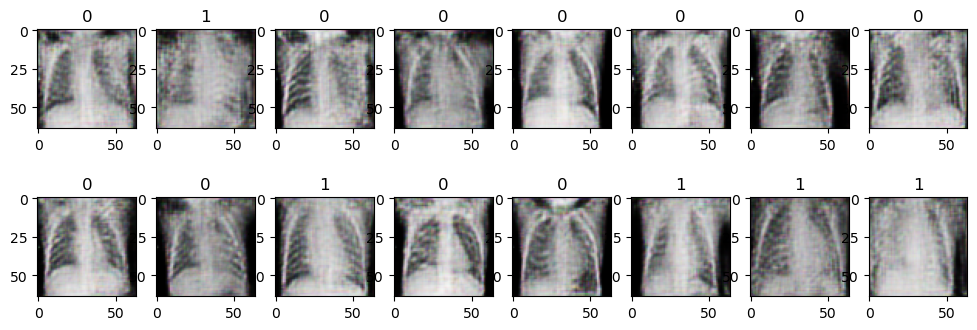

Epoch: 10000
discriminator loss: [tag: 0.247049018740654, labels: 0.007738857064396143], generator loss: [tag: 0.24686279892921448, labels: 0.004355606157332659]
1/1 [==============================] - 0s 28ms/step


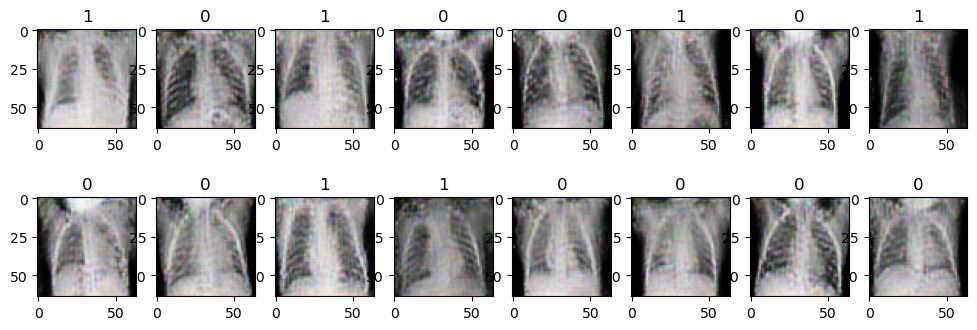

Epoch: 15000
discriminator loss: [tag: 0.222052201628685, labels: 0.0005491209449246526], generator loss: [tag: 0.3458043336868286, labels: 0.0013278869446367025]
1/1 [==============================] - 0s 26ms/step


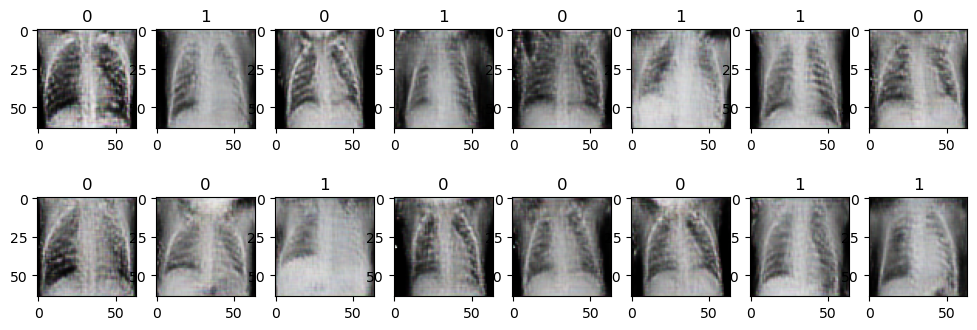

Epoch: 20000
discriminator loss: [tag: 0.02244682051241398, labels: 0.0008054657373577356], generator loss: [tag: 0.29845547676086426, labels: 0.0013539115898311138]
1/1 [==============================] - 0s 26ms/step


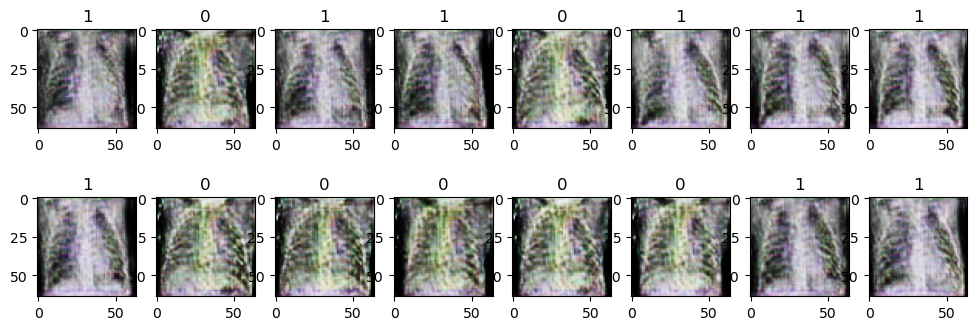

Epoch: 25000
discriminator loss: [tag: 0.016233891248703003, labels: 0.01607208326458931], generator loss: [tag: 0.04824181646108627, labels: 0.0008437228971160948]
1/1 [==============================] - 0s 27ms/step


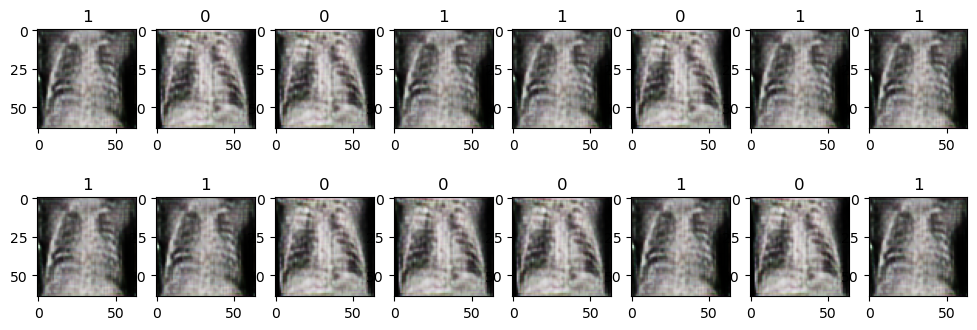

Epoch: 30000
discriminator loss: [tag: 0.16520580649375916, labels: 0.027243247255682945], generator loss: [tag: 0.7700511813163757, labels: 0.0007426546653732657]
1/1 [==============================] - 0s 27ms/step


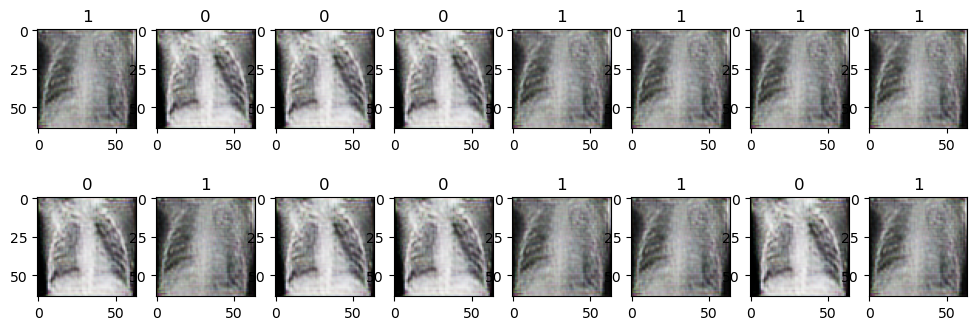

In [16]:
ac_gan.trainAlgorithm(generator, discriminator, GAN)

# Saving GAN h5

In [17]:
generator.save('generator_ablation3.h5')

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Loading saved GAN h5

In [18]:
generator_loaded = tf.keras.models.load_model('generator_ablation3.h5')

# FID

In [19]:
import numpy as np
from numpy import cov, trace, iscomplexobj
from scipy.linalg import sqrtm
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [20]:
vgg = VGG16(include_top=False, weights="imagenet", input_shape=(64,64,3))
vgg_model = Model(inputs=vgg.input, outputs=vgg.layers[-1].output)

In [21]:
def get_activations(images, batch_size=256):
    acts = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        batch = batch.astype("float32")
        act = vgg_model.predict(batch, verbose=0)
        acts.append(act.reshape(len(batch), -1))
    return np.concatenate(acts, axis=0)

In [22]:
def calculate_statistics(activations):
    mu = np.mean(activations, axis=0)
    sigma = np.cov(activations, rowvar=False)
    return mu, sigma

In [23]:
def calculate_fid(mu1, sigma1, mu2, sigma2):
    diff = mu1 - mu2
    covmean = sqrtm(sigma1 @ sigma2)

    if iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff @ diff + trace(sigma1 + sigma2 - 2 * covmean)
    return float(fid)

In [24]:
def fid_vgg(real_imgs, fake_imgs, batch_size=256):
    act1 = get_activations(real_imgs, batch_size)
    act2 = get_activations(fake_imgs, batch_size)

    mu1, sigma1 = calculate_statistics(act1)
    mu2, sigma2 = calculate_statistics(act2)

    fid = calculate_fid(mu1, sigma1, mu2, sigma2)
    return fid

In [25]:
datasetGenerationSize = 30000

noise = tf.random.uniform((datasetGenerationSize, 100), -1, 1)

fake_labels_onehot = tf.keras.utils.to_categorical(
    np.random.choice([0, 1], size=datasetGenerationSize),
    num_classes=2
)

fake_imgs = generator_loaded.predict([noise, fake_labels_onehot])
fake_imgs = np.squeeze(fake_imgs).astype(np.float32)

938/938 [==============================] - 11s 11ms/step


In [26]:
train_dataset = ReadDataset('chest_xray/chest_xray/train',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
X_train, y_train = train_dataset.readImages()

val_data = ReadDataset('chest_xray/chest_xray/val',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
X_val, y_val = val_data.readImages()

test_data = ReadDataset('chest_xray/chest_xray/test',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
X_test, y_test = test_data.readImages()

Loaded 5216 images.
Loaded 16 images.
Loaded 624 images.


In [27]:
real_imgs = np.array(X_train, dtype=np.float32)   # 0–1 scaled
real_imgs = real_imgs / 255.0

In [28]:
act_real = get_activations(real_imgs)
act_fake = get_activations(fake_imgs)


In [29]:
fid_100 = fid_vgg(X_train, fake_imgs)
print("FID 64×64:", fid_100)

FID 64×64: 142.4488362910124


# SSIM

In [30]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def compute_ssim_batch(real_images, fake_images):
    """
    real_images, fake_images: arrays shaped (N, 64, 64, 3) in [0,1]
    returns: average SSIM
    """
    scores = []
    for i in range(len(real_images)):
        r = real_images[i]
        f = fake_images[i]

        score = ssim(r, f, data_range=1.0, channel_axis=2)
        scores.append(score)

    return np.mean(scores)

In [31]:
ssim_score = compute_ssim_batch(X_train, fake_imgs)
print("SSIM:", ssim_score)

SSIM: 0.15618603247360677
